In [1]:
%matplotlib inline

In [2]:
from ssrs.raster import *
from ssrs import Terrain, HRRR
#from typing import Tuple

/home/rthedin/.conda-envs/ssrs_env/lib/python3.10/site-packages/herbie/archive.py:71: UserWarning: herbie xarray accessors could not be imported.You are probably missing the Carpenter_Workshop.If you want to use these functions, try`pip install git+https://github.com/blaylockbk/Carpenter_Workshop.git`
  warnings.warn(


In [3]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from scipy import ndimage

In [4]:
g = 9.81    # m/s^2
rho = 1.225 # kg/m^3
cp = 1005   # J/(kg*K)

In [5]:
# from https://github.com/rthedin/mmctools/blob/feature/SxImprovement/mmctools/coupling/terrain.py#L629
from scipy.interpolate import griddata
def calcSx(xx, yy, zagl, A, dmax, method='linear', verbose=False):
    '''
    Sx is a measure of topographic shelter or exposure relative to a particular
    wind direction. Calculates a whole map for all points (xi, yi) in the domain.
    For each (xi, yi) pair, it uses all v points (xv, yv) upwind of (xi, yi) in
    the A wind direction, up to dmax.
    Winstral, A., Marks D. "Simulating wind fields and snow redistribution using
        terrain-based parameters to model snow accumulation and melt over a semi-
        arid mountain catchment" Hydrol. Process. 16, 3585–3603 (2002)
    Usage
    =====
    xx, yy : array
        meshgrid arrays of the region extent coordinates.
    zagl: arrayi, xr.DataArray
        Elevation map of the region
    A: float
        Wind direction (deg, wind direction convention)
    dmax: float
        Upwind extent of the search
    method: string
        griddata interpolation method. Options are 'nearest', 'linear', 'cubic'.
        Recommended linear or cubic.
    '''
    
    # get resolution (assumes uniform resolution)
    res = xx[1,0] - xx[0,0]
    npoints = 1+int(dmax/res)
    if dmax < res:
        raise ValueError('dmax needs to be larger or equal to the resolution of the grid')
    
    # Get upstream direction
    A = A%360
    if    A==0:   upstreamDirX=0;  upstreamDirY=-1
    elif  A==90:  upstreamDirX=-1; upstreamDirY=0
    elif  A==180: upstreamDirX=0;  upstreamDirY=1
    elif  A==270: upstreamDirX=1;  upstreamDirY=0
    elif  A>0  and A<90:   upstreamDirX=-1; upstreamDirY=-1
    elif  A>90  and A<180:  upstreamDirX=-1; upstreamDirY=1
    elif  A>180 and A<270:  upstreamDirX=1;  upstreamDirY=1
    elif  A>270 and A<360:  upstreamDirX=1;  upstreamDirY=-1

    # change angle notation
    ang = np.deg2rad(270-A)

    # array for interpolation using griddata
    points = np.array( (xx.flatten(), yy.flatten()) ).T
    if isinstance(zagl, xr.DataArray):
        zagl = zagl.values
    values = zagl.flatten()

    # create rotated grid. This way we sample into a interpolated grid that has the exact points we need
    xmin = min(xx[:,0]);  xmax = max(xx[:,0])
    ymin = min(yy[0,:]);  ymax = max(yy[0,:])
    if A%90 == 0:
        # if flow is aligned, we don't need a new grid
        xrot = xx[:,0]
        yrot = yy[0,:]
        xxrot = xx
        yyrot = yy
        elevrot = zagl
    else:
        xrot = np.arange(xmin, xmax+0.1, abs(res*np.cos(ang)))
        yrot = np.arange(ymin, ymax+0.1, abs(res*np.sin(ang)))
        xxrot, yyrot = np.meshgrid(xrot, yrot, indexing='ij')
        elevrot = griddata( points, values, (xxrot, yyrot), method=method )

    # create empty rotated Sx array
    Sxrot = np.empty(np.shape(elevrot));  Sxrot[:,:] = np.nan

    for i, xi in enumerate(xrot):
        if verbose: print(f'Computing Sx... {100*(i+1)/len(xrot):.1f}%  ', end='\r')
        for j, yi in enumerate(yrot):

            # Get elevation profile along the direction asked
            isel = np.linspace(i-upstreamDirX*npoints+upstreamDirX, i, npoints, dtype=int)
            jsel = np.linspace(j-upstreamDirY*npoints+upstreamDirY, j, npoints, dtype=int)
            try:
                xsel = xrot[isel]
                ysel = yrot[jsel]
                elev = elevrot[isel,jsel]
            except IndexError:
                # At the borders, can't get a valid positions
                xsel = np.zeros(np.size(isel))  
                ysel = np.zeros(np.size(jsel))
                elev = np.zeros(np.size(isel)) 

            # elevation of (xi, yi), for convenience
            elevi = elev[-1]

            Sxrot[i,j] = np.nanmax(np.rad2deg( np.arctan( (elev[:-1] - elevi)/(((xsel[:-1]-xi)**2 + (ysel[:-1]-yi)**2)**0.5) ) ))

    # interpolate results back to original grid
    pointsrot = np.array( (xxrot.flatten(), yyrot.flatten()) ).T
    Sx = griddata( pointsrot, Sxrot.flatten(), (xx, yy), method=method )

    return Sx

# Example of thermal and orographic updraft computations

## - Get input information

In [6]:
# Variables that will need to be inputs

# SW corner lat/lon
southwest_lonlat=(-106.21, 42.78)  # TOTW

# date in UTC. MST=UTC-7
time = (2021, 6, 15, 21, 0)

# grid parameters
extent = [0, 0, 50000, 50000]  # [xmin, ymin, xmax, xmax]
res = 50

height=150

## 1. Getting HRRR data

In [7]:
# Get HRRR data
hrrr = HRRR(date=f'{time[0]}-{time[1]:02d}-{time[2]:02d} {time[3]:02d}:{time[4]:02d}')

Using date
🏋🏻‍♂️ Found 2021-Jun-15 21:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       


## 1.1 Compute and plot some quantities

In [8]:
# Compute wstar
wstar, xx, yy = hrrr.get_convective_velocity(southwest_lonlat, extent, res=res)

# Compute albedo
albedo, xx, yy = hrrr.get_albedo(southwest_lonlat, extent, res)

# Get quantities
gflux_Wm2, xx, yy = hrrr.getSingleVariableOnGrid(':(GFLUX):',      southwest_lonlat, extent, res)   # ground heat flux
pot,       xx, yy = hrrr.getSingleVariableOnGrid(':(POT):',        southwest_lonlat, extent, res)   # potential temp at 2m
zi,        xx, yy = hrrr.getSingleVariableOnGrid(':(HPBL):',       southwest_lonlat, extent, res)   # boundary layer height
cloud,     xx, yy = hrrr.getSingleVariableOnGrid(':(LCDC):',       southwest_lonlat, extent, res)   # cloud coverage
Lu,        xx, yy = hrrr.getSingleVariableOnGrid(':ULWRF:surface', southwest_lonlat, extent, res)   # long wave upward
Ld,        xx, yy = hrrr.getSingleVariableOnGrid(':DLWRF:surface', southwest_lonlat, extent, res)   # long wave downward
Su,        xx, yy = hrrr.getSingleVariableOnGrid(':USWRF:surface', southwest_lonlat, extent, res)   # short wave upward
Sd,        xx, yy = hrrr.getSingleVariableOnGrid(':DSWRF:surface', southwest_lonlat, extent, res)   # short wave downward
sensible,  xx, yy = hrrr.getSingleVariableOnGrid(':SHTFL:surface', southwest_lonlat, extent, res)   # sensible heat flux
latent,    xx, yy = hrrr.getSingleVariableOnGrid(':LHTFL:surface', southwest_lonlat, extent, res)   # latent heat flux
moisture,  xx, yy = hrrr.getSingleVariableOnGrid(':MSTAV:',        southwest_lonlat, extent, res)   # moisture
groundT,   xx, yy = hrrr.getSingleVariableOnGrid(':TMP:surface',   southwest_lonlat, extent, res)   # ground temp
snow,      xx, yy = hrrr.getSingleVariableOnGrid(':SNOWC',         southwest_lonlat, extent, res)   # snow cover


Note: Returning a list of [5] xarray.Datasets because of multiple hypercubes.


In [9]:
# Compute quantities
Lnet = Ld-Lu                  # gain of energy by the surface, positive when it is towards the surface
net_rad = Sd - Su + Ld - Lu   #Rn1
qs = sensible + latent - gflux_Wm2 # minus for sign convention

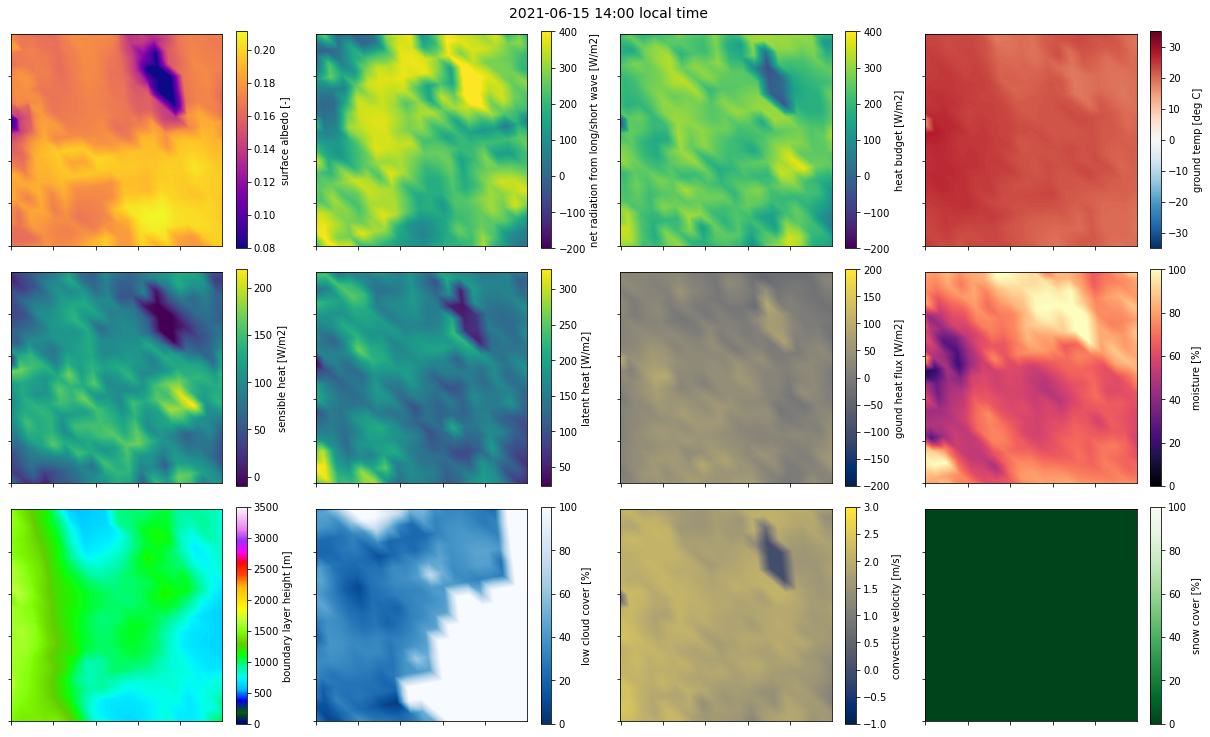

In [10]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(17,10.4))
axs=axs.flatten()

cmap='RdBu_r'
vmin=-200
vmax=400

cm = axs[0].pcolormesh(xx, yy, albedo, shading='auto', cmap='plasma')
fig.colorbar(cm, ax=axs[0], label='surface albedo [-]')

cm = axs[1].pcolormesh(xx, yy, net_rad, shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(cm, ax=axs[1], label='net radiation from long/short wave [W/m2]')

cm = axs[2].pcolormesh(xx, yy, qs, shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(cm, ax=axs[2], label='heat budget [W/m2]')

cm = axs[3].pcolormesh(xx, yy, groundT-273, shading='auto', cmap=cmap, vmin=-35, vmax=35)
fig.colorbar(cm, ax=axs[3], label='ground temp [deg C]')


cm = axs[4].pcolormesh(xx, yy, sensible, shading='auto', cmap='viridis')
fig.colorbar(cm, ax=axs[4], label='sensible heat [W/m2]')

cm = axs[5].pcolormesh(xx, yy, latent, shading='auto', cmap='viridis')
fig.colorbar(cm, ax=axs[5], label='latent heat [W/m2]')

cm = axs[6].pcolormesh(xx, yy, gflux_Wm2, shading='auto', cmap='cividis', vmin=-200, vmax=200)
fig.colorbar(cm, ax=axs[6], label='gound heat flux [W/m2]')

cm = axs[7].pcolormesh(xx, yy, moisture, shading='auto', cmap='magma', vmin=0, vmax=100)
fig.colorbar(cm, ax=axs[7], label='moisture [%]')


cm = axs[8].pcolormesh(xx, yy, zi, shading='auto', cmap='gist_ncar', vmin=0, vmax=3500)
fig.colorbar(cm, ax=axs[8], label='boundary layer height [m]')

cm = axs[9].pcolormesh(xx, yy, cloud, shading='auto', cmap='Blues_r', vmin=0, vmax=100)
fig.colorbar(cm, ax=axs[9], label='low cloud cover [%]')

cm = axs[10].pcolormesh(xx, yy, wstar, shading='auto', cmap='cividis', vmin=-1, vmax=3)
fig.colorbar(cm, ax=axs[10], label='convective velocity [m/s]')

cm = axs[11].pcolormesh(xx, yy, snow, shading='auto', cmap='Greens_r', vmin=0, vmax=100)
fig.colorbar(cm, ax=axs[11], label='snow cover [%]')


fig.suptitle(f'{time[0]}-{time[1]:02d}-{time[2]:02d} {time[3]-7:02d}:{time[4]:02d} local time', fontsize=14)
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

## 2. Get the variables that would be available within `compute_thermals` and `compute_adjusted_orographic_updraft` in SSRS

In [11]:
# longitude in degrees East (unusual; for GRIB)
min_lat = southwest_lonlat[1] -0.15
min_lon = 180-southwest_lonlat[0] -0.9
max_lat = min_lat + 0.7
max_lon = min_lon + 1.1

# longitude in degrees West (typical)
min_lon_degW = southwest_lonlat[0] -0.1
max_lon_degW = min_lon_degW + 0.8

# ger reference location
xSW, ySW = transform_coordinates('EPSG:4326','ESRI:102008', southwest_lonlat[0], southwest_lonlat[1])
xref = xSW[0]
yref = ySW[0]    
extentref = [extent[0]+xref, extent[1]+yref, extent[2]+xref, extent[3]+yref]

# Get terrain
terr = Terrain([min_lon_degW, min_lat, max_lon_degW,  max_lat], out_dir='tempTerrain')
terr.download(layers=['DEM','Aspect Degrees'])

Terrain: Bounds set to [-106.31, 42.63, -105.51, 43.33]
Terrain: Found saved raster data for DEM
Terrain: Found saved raster data for Aspect Degrees


In [12]:
# Create grid
x = np.arange(extent[0], extent[2], res)
y = np.arange(extent[1], extent[3], res)
xx, yy = np.meshgrid(x, y, indexing='ij')
nPointsx = int((extent[2]-extent[0])/res)
nPointsy = int((extent[3]-extent[1])/res)

# Get elevation map and aspect as done by SSRS
filedem = terr.get_raster_fpath('DEM')
elev = get_raster_in_projected_crs(filedem, extentref, (nPointsx, nPointsy), (res, res), 'ESRI:102008')

fileaspect = terr.get_raster_fpath('Aspect Degrees')
aspect = get_raster_in_projected_crs(fileaspect, extentref, (nPointsx, nPointsy), (res, res), 'ESRI:102008')


## 3. Thermal updrafts

### 3.1 Load WFIP data

Data processed by Eliot. Used to inform the updraft-generation module.

In [13]:
wfip = xr.open_dataset('/projects/car/rthedin/OpenFOAM/rthedin-6/run/totw_2022/thermalUpdraftModeling/updraft_conditions.nc')

### 3.2 Compute thermal updrafts functions

In [14]:
def getRandomPointsWeighted (weight, n, nRealization=1):
    
    normalweight = weight/np.sum(weight)
    
    choicesum = np.zeros_like(weight).flatten()
    for i in range(nRealization):
        randindices = np.random.choice( np.arange(np.size(choicesum)), size=n, replace = False, p=normalweight.flatten())
        # create a current-iteration result
        choice = np.zeros_like(weight).flatten()
        choice[randindices] = 1
        # accumulate
        choicesum = choicesum +choice

    # sum of realizations
    choicesum = choicesum.reshape(np.shape(weight))
    # last realization, choice
    choice = choice.reshape(np.shape(weight))
    
    return choice, choicesum

In [15]:
def getObs_maxw(height, hrrr, southwest_lonlat, extent, res):
    # Add a weight based on experimental observations at the WFIP2 site if height is low
    if height<=200:
        wfip = xr.open_dataset('/projects/car/rthedin/OpenFOAM/rthedin-6/run/totw_2022/thermalUpdraftModeling/updraft_conditions.nc')
        rho = 1.225 # kg/m^3
        cp = 1005   # J/(kg*K)

        # Get mean wspd
        u, xx, yy = hrrr.getSingleVariableOnGrid(':UGRD:80 m above ground',       southwest_lonlat, extent, res)   # u component of the wind at 80 AGL
        v, xx, yy = hrrr.getSingleVariableOnGrid(':UGRD:80 m above ground',       southwest_lonlat, extent, res)   # u component of the wind at 80 AGL
        wspd = (u**2+v**2)**0.5
        meanwspd = np.mean(wspd)

        # Get heat flux
        gflux_Wm2, xx, yy = hrrr.getSingleVariableOnGrid(':(GFLUX):',      southwest_lonlat, extent, res)   # ground heat flux
        sensible,  xx, yy = hrrr.getSingleVariableOnGrid(':SHTFL:surface', southwest_lonlat, extent, res)   # sensible heat flux
        latent,    xx, yy = hrrr.getSingleVariableOnGrid(':LHTFL:surface', southwest_lonlat, extent, res)   # latent heat flux
        hfx = (sensible + latent - gflux_Wm2 )/(rho*cp)
        meanhfx = np.mean(hfx)

        # Get the vertical speed statistics
        wfiph = wfip.interp(height=height).squeeze(drop=True)
        wdata = wfiph.where( (wfiph.wind_speed>meanwspd-1 ) & ( wfiph.wind_speed<meanwspd+1) &
                             (wfiph.hfx>meanhfx-0.025 )     & ( wfiph.hfx<meanhfx+0.025),       drop=True )['vertical_air_velocity']#.to_dataframe().agg(['count','min','mean','max','std'])
        #wmin, wmax, wmean, wstd = wdata.min().values, wdata.max().values, wdata.mean().values, wdata.std().values
        wmax = wdata.max().values

        # Create distribution (experimental)
        #distr = stats.truncnorm( (wmin-wmean)/wstd, (wmax-wmean)/wstd, loc=wmean, scale=wstd)
        #values = distr.rvs(1000)
        
        return wmax

In [16]:
def compute_thermals(
    aspect: np.ndarray,  # terrain aspect, used for weighting
    southwest_lonlat: Tuple[float, float], 
    extent: Tuple[float, float, float, float],  # xmin, ymin, xmax, ymax
    res: int,   # uniform resolution
    time: Tuple[int, int, int, int, int],  # y, m, d, hour, min
    height: float = 200,
    wfipInformed: bool = True
    ) -> np.ndarray:
    '''
    Returns field of thermals based on Allen (2006)
    '''
    
    # TODO: Loop over a list of `time`s
    
    # Get hrrr data
    hrrr = HRRR(valid_date=f'{time[0]}-{time[1]:02d}-{time[2]:02d} {time[3]:02d}:{time[4]:02d}')

    # Compute convective velocity
    wstar,  xx, yy = hrrr.get_convective_velocity(southwest_lonlat, extent, res=res)
    # Compute albedo
    albedo, xx, yy = hrrr.get_albedo(southwest_lonlat, extent, res)
    # Get boundary layer height
    zi,     xx, yy = hrrr.getSingleVariableOnGrid(':(HPBL):',       southwest_lonlat, extent, res)   # boundary layer height


    # Define updraft shape factors
    r1r2shape = np.array([0.14, 0.25, 0.36, 0.47, 0.58, 0.69, 0.80])
    Kshape = np.array([[1.5352, 2.5826, -0.0113, -0.1950, 0.0008],
                       [1.5265, 3.6054, -0.0176, -0.1265, 0.0005],
                       [1.4866, 4.8356, -0.0320, -0.0818, 0.0001],
                       [1.2042, 7.7904,  0.0848, -0.0445, 0.0001],
                       [0.8816, 13.9720, 0.3404, -0.0216, 0.0001],
                       [0.7067, 23.9940, 0.5689, -0.0099, 0.0002],
                       [0.6189, 42.7965, 0.7157, -0.0033, 0.0001]])


    # Create weight for likeliness of thermals in space
    albedofactor = (0.1/(albedo)**0.5)
    spatialWeight = ( wstar**1 + albedofactor )**2
    # Mask the edges so no thermals there
    fringe= 3000 # in [m]
    ifringe = int(fringe/res)
    spatialWeight[0:ifringe,:] = spatialWeight[-ifringe:,:] = 0
    spatialWeight[:,0:ifringe] = spatialWeight[:,-ifringe:] = 0

    # Get thermal parameters
    ziavg = np.mean(zi)
    zzi = height/zi
    zziavg = height/ziavg
    assert ziavg > 300, 'The boundary layer is too shallow for thermals'

    # Calcualte average updraft size
    rbar=(.102*zzi**(1/3))*(1-(.25*zzi))*zi

    # Calculate average updraft strength (G. Young)
    wT = wstar * (zzi**(1/3)) * (1.3-zzi)

    # Size gain around a mean, based on albedo
    rgain =1.4*(0.4/(albedo))

    # Calculate inner and outer radius of rotated trapezoid updraft
    r2 = rbar*rgain;  r2[r2<10] = 10
    r1r2 = 0.0011*r2+0.14
    r1r2[r2>600] = 0.8
    r1 = r1r2*r2

    # Determine number of thermals
    nThermals = int ( 0.6*(extent[2]-extent[0])*(extent[3]-extent[1])/(ziavg*np.mean(r2)) )

    # Create strength gains, based on wstar
    wgain = 0.7*wstar

    # Multiply average updraft strength by the gain
    wTbar = wT*wgain

    # Calculate strength at center of rotated trapezoid updraft
    wpeak=(3*wTbar*((r2**3)-(r2**2)*r1)) / ((r2**3)-(r1**3))

    # Create a realization of thermal's center location
    print(f'Creating {nThermals} thermals. The average boundary layer height is {ziavg:1f}')
    wt_init, sumOfRealizations = getRandomPointsWeighted(weight=spatialWeight, n=nThermals, nRealization=1)

    # Get distances to closest thermal center
    wt_init1 = np.zeros_like(wt_init)
    wt_init1[wt_init>0]=1
    dist = ndimage.distance_transform_edt(np.logical_not(wt_init1)) * res

    # Calculate updraft velocity
    r=dist
    rr2=r/r2

    # Calculate shape parameters
    k1 = np.ones_like(r1r2)
    k2 = np.ones_like(r1r2)
    k3 = np.ones_like(r1r2)
    k4 = np.ones_like(r1r2)
    k1 = k1*Kshape[6,0];                                      k2 = k2*Kshape[6,1];                                      k3 = k3*Kshape[6,2];                                      k4 = k4*Kshape[6,3]
    k1[r1r2<(0.5*r1r2shape[6]+r1r2shape[5])] = Kshape[5,0];   k2[r1r2<(0.5*r1r2shape[6]+r1r2shape[5])] = Kshape[5,1];   k3[r1r2<(0.5*r1r2shape[6]+r1r2shape[5])] = Kshape[5,2];   k4[r1r2<(0.5*r1r2shape[6]+r1r2shape[5])] = Kshape[5,3]
    k1[r1r2<(0.5*r1r2shape[5]+r1r2shape[4])] = Kshape[4,0];   k2[r1r2<(0.5*r1r2shape[5]+r1r2shape[4])] = Kshape[4,1];   k3[r1r2<(0.5*r1r2shape[5]+r1r2shape[4])] = Kshape[4,2];   k4[r1r2<(0.5*r1r2shape[5]+r1r2shape[4])] = Kshape[4,3]
    k1[r1r2<(0.5*r1r2shape[4]+r1r2shape[3])] = Kshape[3,0];   k2[r1r2<(0.5*r1r2shape[4]+r1r2shape[3])] = Kshape[3,1];   k3[r1r2<(0.5*r1r2shape[4]+r1r2shape[3])] = Kshape[3,2];   k4[r1r2<(0.5*r1r2shape[4]+r1r2shape[3])] = Kshape[3,3]
    k1[r1r2<(0.5*r1r2shape[3]+r1r2shape[2])] = Kshape[2,0];   k2[r1r2<(0.5*r1r2shape[3]+r1r2shape[2])] = Kshape[2,1];   k3[r1r2<(0.5*r1r2shape[3]+r1r2shape[2])] = Kshape[2,2];   k4[r1r2<(0.5*r1r2shape[3]+r1r2shape[2])] = Kshape[2,3]
    k1[r1r2<(0.5*r1r2shape[2]+r1r2shape[1])] = Kshape[1,0];   k2[r1r2<(0.5*r1r2shape[2]+r1r2shape[1])] = Kshape[1,1];   k3[r1r2<(0.5*r1r2shape[2]+r1r2shape[1])] = Kshape[1,2];   k4[r1r2<(0.5*r1r2shape[2]+r1r2shape[1])] = Kshape[1,3]
    k1[r1r2<(0.5*r1r2shape[1]+r1r2shape[0])] = Kshape[0,0];   k2[r1r2<(0.5*r1r2shape[1]+r1r2shape[0])] = Kshape[0,1];   k3[r1r2<(0.5*r1r2shape[1]+r1r2shape[0])] = Kshape[0,2];   k4[r1r2<(0.5*r1r2shape[1]+r1r2shape[0])] = Kshape[0,3]

    # Calculate the smooth vertical velocity distribution
    ws = (1/(1+(k1*abs(rr2+k3))**k2)) + k4*rr2
    # no negative updrafts
    ws[ws<0] = 0
    # Set to zero if above the boundary layer
    ws[zi<height] = 0

    # Calculate downdraft velocity at edges of updrafts
    wl = (np.pi/6)*np.sin(rr2*np.pi)
    wl[( (dist<r1) | (rr2>2))] = 0
    wd = 2.5*wl*(zzi-0.5)
    wd[((zzi<0.5) | (zzi>0.9))] = 0
    wd[wd<0]=0

    # Combine fields
    w = wpeak*ws + wd*wTbar

    # Scale it to fit experimental data (optional)
    if wfipInformed:
        if height<= 200:
            wmax = getObs_maxw(height, hrrr, southwest_lonlat, extent, res)
            w = w*wmax/np.max(w)
        else:
            print('The height requested is higher than observations. Skipping correction.')

    # Environment sink
    # we = np.zeros_like(w)
    # Stretch updraft field to blend with sink at edge
    # w[dist>r1] = (w*(1-we/wpeak)+we)[dist>r1]
    
    return w

### 3.3 Example of thermal updraft field

In [17]:
wt = compute_thermals(aspect, southwest_lonlat, extent, res, time, height, wfipInformed=True)

Using valid_date
🏋🏻‍♂️ Found 2021-Jun-15 21:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
Note: Returning a list of [5] xarray.Datasets because of multiple hypercubes.
Creating 8527 thermals. The average boundary layer height is 1018.825315


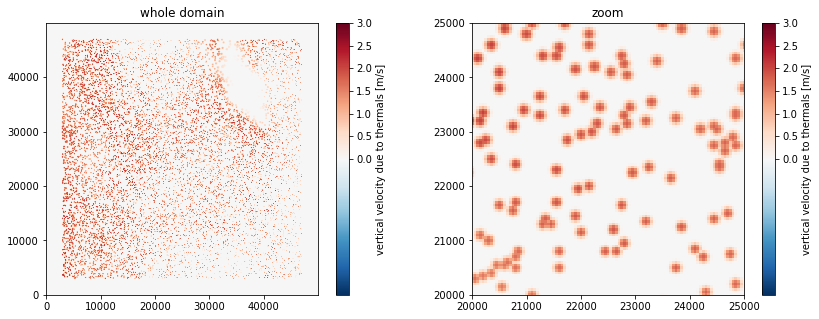

In [18]:
norm=colors.TwoSlopeNorm(vcenter=0, vmin=-0.1, vmax=3)

fig, axs = plt.subplots(ncols=2, figsize=(14,5))

cm = axs[0].pcolormesh(xx, yy, wt, shading='auto',  norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[0], label='vertical velocity due to thermals [m/s]')
axs[0].set_title('whole domain')

cm = axs[1].pcolormesh(xx, yy, wt, shading='auto',  norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[1], label='vertical velocity due to thermals [m/s]')
axs[1].set_title('zoom')
axs[1].set_xlim([20000, 25000])
axs[1].set_ylim([20000, 25000])

for ax in axs:
    ax.set_aspect('equal')
plt.show()

# Orographic updraft

In [19]:
def compute_adjusted_orographic_updraft (
    wspeedAtRefHeight: np.ndarray,
    wdirn: np.ndarray,
    elevation: np.ndarray,
    tc: float,
    res: float,
    h: float = 80,
    #min_updraft_val: float = -5.,
    returnOriginal: bool =False
) -> np.ndarray:
    '''
    Returns the dimensional adjusted orographic updraft value
   
    Parameters:
    ===========
    wspeedAtRefHeight:
        Wind speed at a reference height, often 80 m AGL
    wdirn:
        Wind direction at a reference height
    elevation:
        Your z_mat
    tc:
        Terrain complexity.
        Guideline: 0.2 for WY, 0.8 for Appalachian
    res:
        Resolution
    h:
        Height of interest. Defaults to 80
    min_updraft_val:
        Minimum value used to clip the final adjusted model. Placeholder.
    returnOriginal:
        Whether or not also return original model
       
    Returns:
    ========
    w0adj:
        numpy array containing dimensional w0 adjusted value
    '''
    from scipy.ndimage import gaussian_filter
    from ssrs.layers import compute_aspect_degrees, compute_slope_degrees, compute_orographic_updraft
   
    # Constants for height adjustment
    a=0.00004;  b=0.0028;   c=0.8
    d=0.35;     e=0.095;    f= -0.09

    # Compute dummy grid with proper resolution
    xx, yy = np.meshgrid(np.arange(0,res*np.shape(elevation)[0], res),
                         np.arange(0,res*np.shape(elevation)[1], res), indexing='ij')
    # Compute shelterness angle (180 for flipped behavior)
    wdir_sx =  (wdir+90)%360  # wdir for sx due to weird convention
    sx400 = calcSx(xx, yy, elevation, np.mean(wdir_sx)+180, 400)

    # Get terrain quantities
    sigma_in_m = min(0.8*h + 16, 300) # size of kernel in meters
    zblur = gaussian_filter(elevation, sigma=sigma_in_m/res)
    slopeblur = compute_slope_degrees(zblur, res)
    aspectblur = compute_aspect_degrees(zblur, res)
    slope = compute_slope_degrees(elevation, res)
    aspect = compute_aspect_degrees(elevation, res)

    # Calculate adjusting factors
    factor_height = ( a*h**2 + b*h + c ) * d**(-np.cos(np.deg2rad(slopeblur)) + e) + f
    factor_sx = 1 + np.tan(np.deg2rad(sx400))
    factor_tc = 1 + tc
    # Combine all factors
    F = factor_tc * factor_sx / factor_height

    # Compute dimensional w0 based on original model and a reference wind speed at a reference height
    w0 =  wspeedAtRefHeight * np.sin(np.deg2rad(slope)) * np.cos(np.deg2rad(((-wdir+90)%360)-aspect))
    w0blur = wspeedAtRefHeight * np.sin(np.deg2rad(slopeblur)) * np.cos(np.deg2rad(((-wdir+90)%360)-aspectblur))
    
    # Adjust w0
    w0adj =  F * w0blur

    if returnOriginal:
        return w0adj, w0
    else:
        return w0adj

## 4.1 Example of orographic updraft

In [20]:
wdir = 270        # 270 is W
wspdAt80m = 8
height=80

In [21]:
w0adj, w0 = compute_adjusted_orographic_updraft(wspeedAtRefHeight = np.ones_like(xx)*wspdAt80m,
                                                wdirn = np.ones_like(xx)*wdir,
                                                elevation = elev,
                                                tc = 0.2, # WY terrain
                                                res = res,
                                                h = height,
                                                returnOriginal=True)

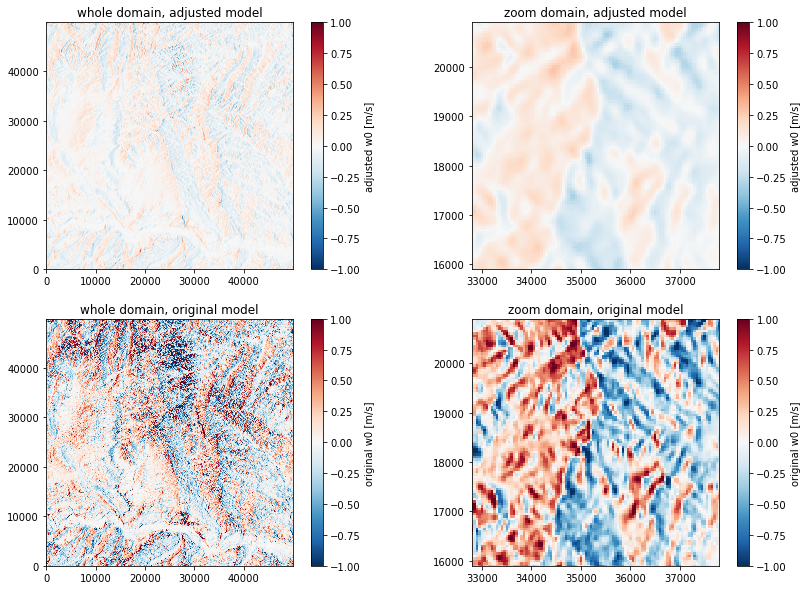

In [23]:
norm=colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14,10))
axs=axs.flatten()

cm = axs[0].pcolormesh(xx, yy, np.transpose(w0adj), shading='auto', norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[0], label='adjusted w0 [m/s]')
axs[0].set_title('whole domain, adjusted model')

cm = axs[1].pcolormesh(xx, yy, np.transpose(w0adj), shading='auto', norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[1], label='adjusted w0 [m/s]')
axs[1].set_title('zoom domain, adjusted model')
axs[1].set_xlim([32800, 37800])
axs[1].set_ylim([15900, 20900])


cm = axs[2].pcolormesh(xx, yy, np.transpose(w0), shading='auto', norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[2], label='original w0 [m/s]')
axs[2].set_title('whole domain, original model')

cm = axs[3].pcolormesh(xx, yy, np.transpose(w0), shading='auto', norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[3], label='original w0 [m/s]')
axs[3].set_title('zoom domain, original model')
axs[3].set_xlim([32800, 37800])
axs[3].set_ylim([15900, 20900])


for ax in axs:
    ax.set_aspect('equal')
plt.show()